# Making Maps with Cartopy

**Requirements:** The `conda/analysis3-20.07` (or later) module on the VDI/gadi (or your own up-to-date cookbook installation).

This tutorial runs through a series of examples that demonstrate how to make maps using data from the COSIMA Cookbook. This tutorial focusses on mapping with `Cartopy`. 

Although in principle there is nothing wrong with using `Basemap`, you should note that `Basemap` is  [deprecated](https://matplotlib.org/basemap/) and it is no longer actively developed or supported. Furthermore, it is not included in CMS curated `conda` environments at NCI.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cosima_cookbook as cc

We will use the SST field from a 0.25° resolution experiment as our sample data. These maps should work with any 2D data.

In [2]:
session = cc.database.create_session()

expt = '025deg_jra55v13_iaf_gmredi6'
variable = 'surface_temp'
darray = cc.querying.getvar(expt, variable, session, frequency='1 monthly', n=-1)
SST = darray.mean('time') - 273.15; # convert from degrees K to degrees C

## Vanilla

You can always make a vanilla plot of this data using `xarray`...

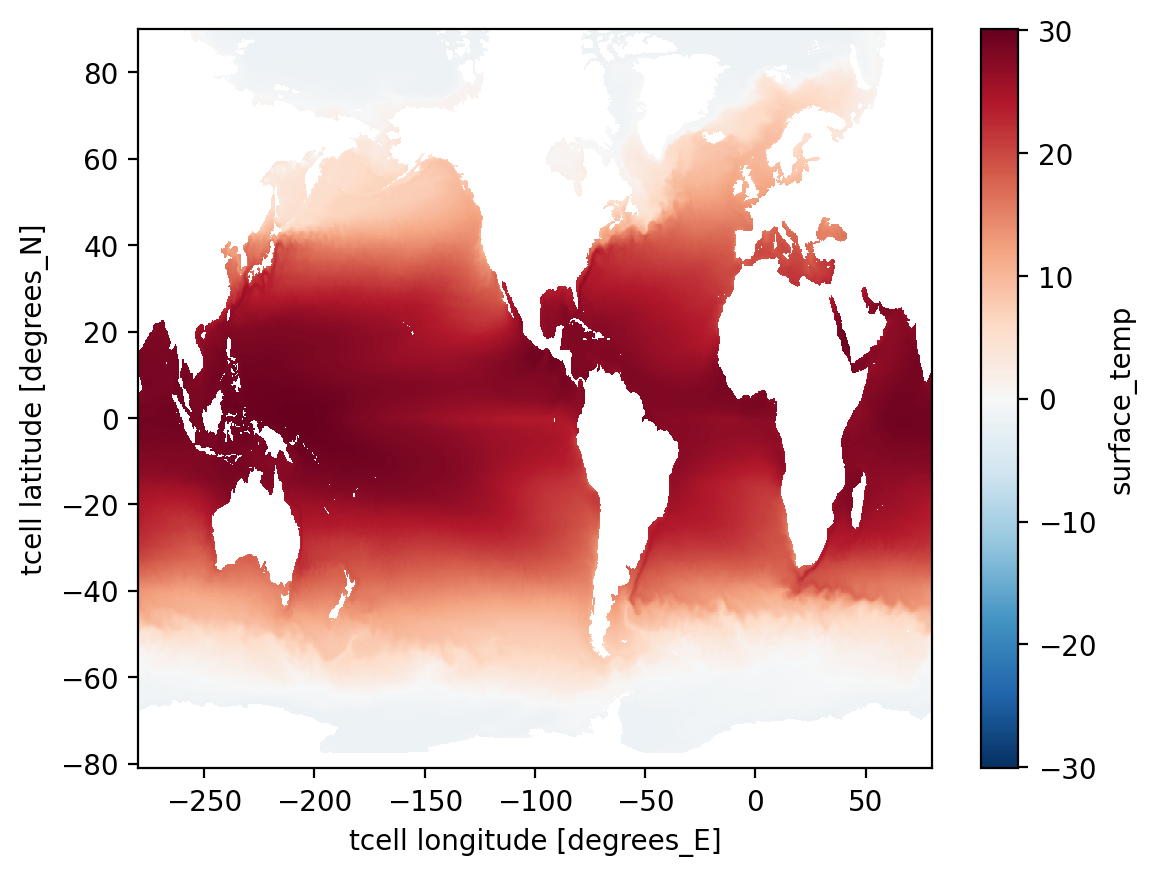

In [3]:
SST.plot();

..., but this won't cut the mustard for publication. Also, note that there is distortion in the tripole region, north of 65°N.

## Using Cartopy
Instead, let's plot the same data with cartopy. This example uses the `Robinson` global projection -- but note that key argument in the plot function: `transform=ccrs.PlateCarree()` -- which is needed every time you plot something with cartopy. (Confusingly, you could also use a `PlateCarree` projection, not to be confused with the transformation ...)

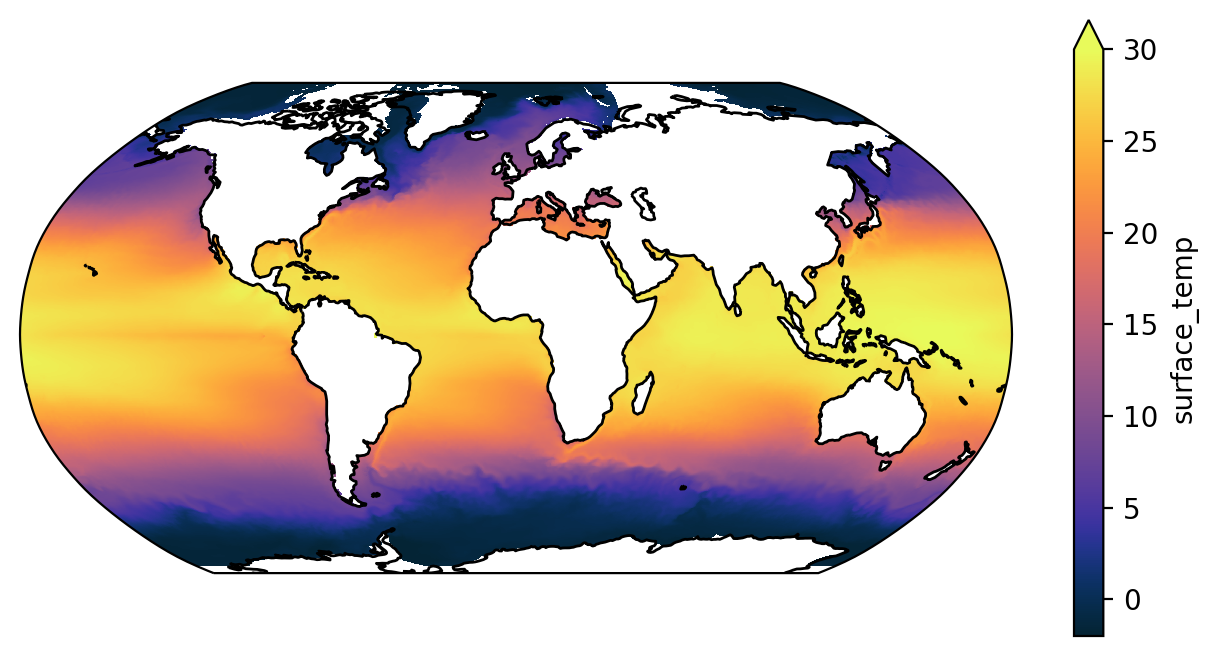

In [4]:
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson())

SST.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='xt_ocean', y='yt_ocean', cmap=cm.cm.thermal, vmin=-2, vmax=30)

ax.coastlines();

You can see that this looks a little better. 

## Colouring in the land
Personally, I don't like such a huge colorbar, and would prefer the land to be something other than white. So I am more inclined to do something like the following.

In [5]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

However, there is still a glitch in this plot -- because data in the tripole region is distorted. This occurs because the axes `xt_ocean` and `yt_ocean` are actually incorrect in the tripole region. 

## Fixing the tripole
Instead, we need to plot with the 2D arrays of x and y locations -- `geolon_t` and `geolat_t` which we save as static data from each run.

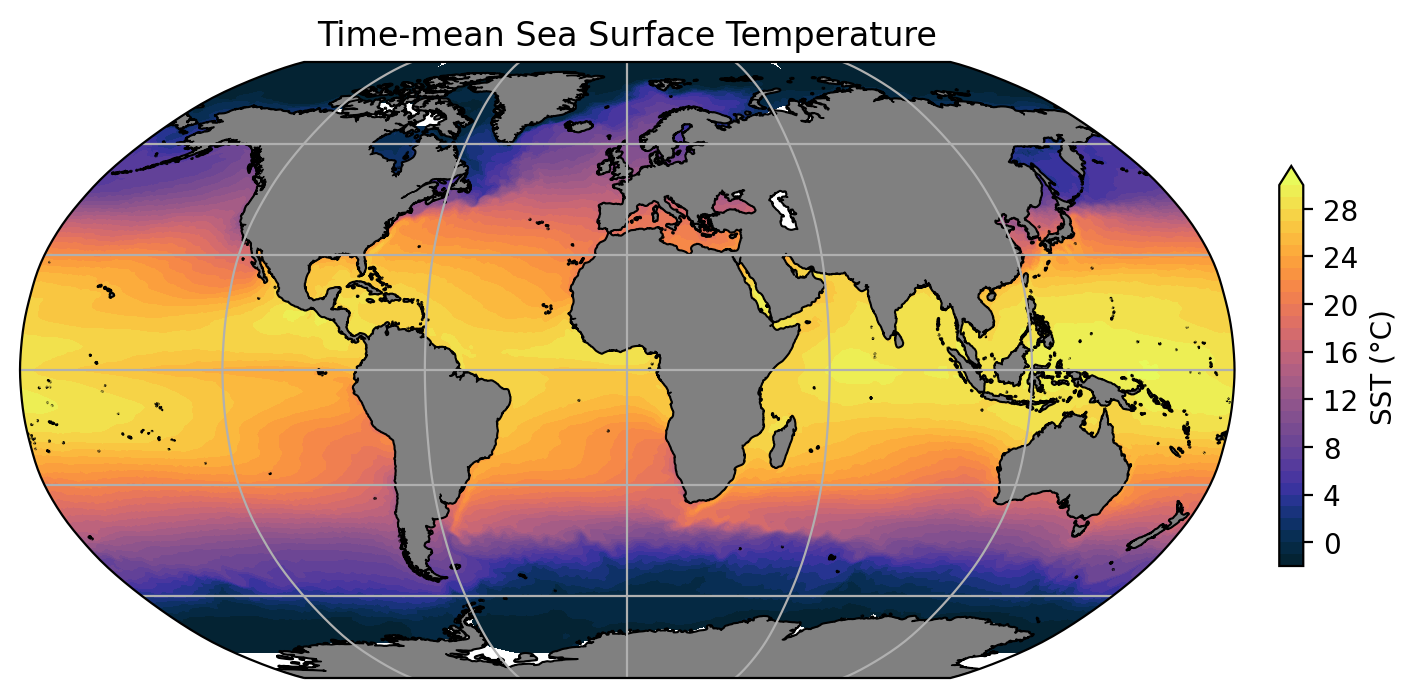

In [6]:
geolon_t = cc.querying.getvar(expt, 'geolon_t', session, n=-1)
geolat_t = cc.querying.getvar(expt, 'geolat_t', session, n=-1)

# assign 
SST = SST.assign_coords({'latitude': geolat_t, 'longitude': geolon_t})

plt.figure(figsize=(8,4))

ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)

p1 = SST.plot.contourf(ax=ax,
                       x='longitude', y='latitude',
                       levels=33, vmin=-2, vmax=30,
                       cmap=cm.cm.thermal,
                       transform=ccrs.PlateCarree(),
                       add_colorbar=False)

plt.title('Time-mean Sea Surface Temperature')

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('SST (°C)');

OK, so that's a bit better. But you may have noticed that we had to use `contourf` to make this map: we can't use `pcolormesh` in this instance, because `geolon_t` and `geolat_t` are masked arrays (and `pcolormesh` can't cope with underfined coordinates). Your options here are to:
* Try contourf instead - it should work;
* Use `pcolor`, noting that this sometimes very slow;
* Read in a file that we prepared earlier ...

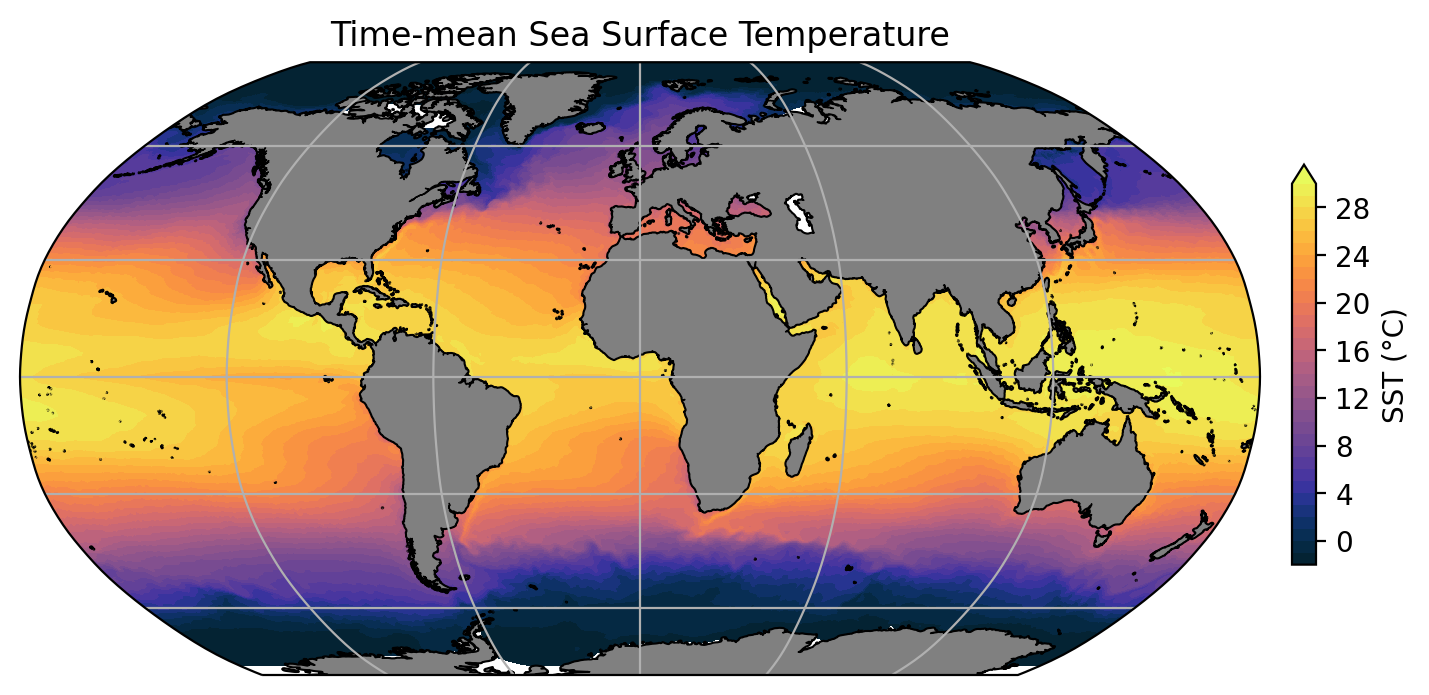

In [7]:
# these lon/lat arrays are NOT masked
geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

SST = SST.assign_coords({'latitude': geolat_t, 'longitude': geolon_t})

plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
                
p1 = SST.plot(ax=ax,
               x='longitude', y='latitude',
               levels=33, vmin=-2, vmax=30,
               cmap=cm.cm.thermal,
               transform=ccrs.PlateCarree(),
               add_colorbar=False)

plt.title('Time-mean Sea Surface Temperature')

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('SST (°C)');

This is about as good as we can get. Note that there are some mismatches between the coastlines in the model and reality, principally around Antarctica and the Canadian Archipelago. Also, note that the `ocean_grid_025.nc` file used here will only work for 0.25° resolution cases - check to see if others are available.

## Projections
Here are a few interesting projections you can use with cartopy that might be good for other applications. Note that if you decide to use a map region which extends north of 65°N, you should use the 2D coordinte files as per above.

### Near Sided Perspective

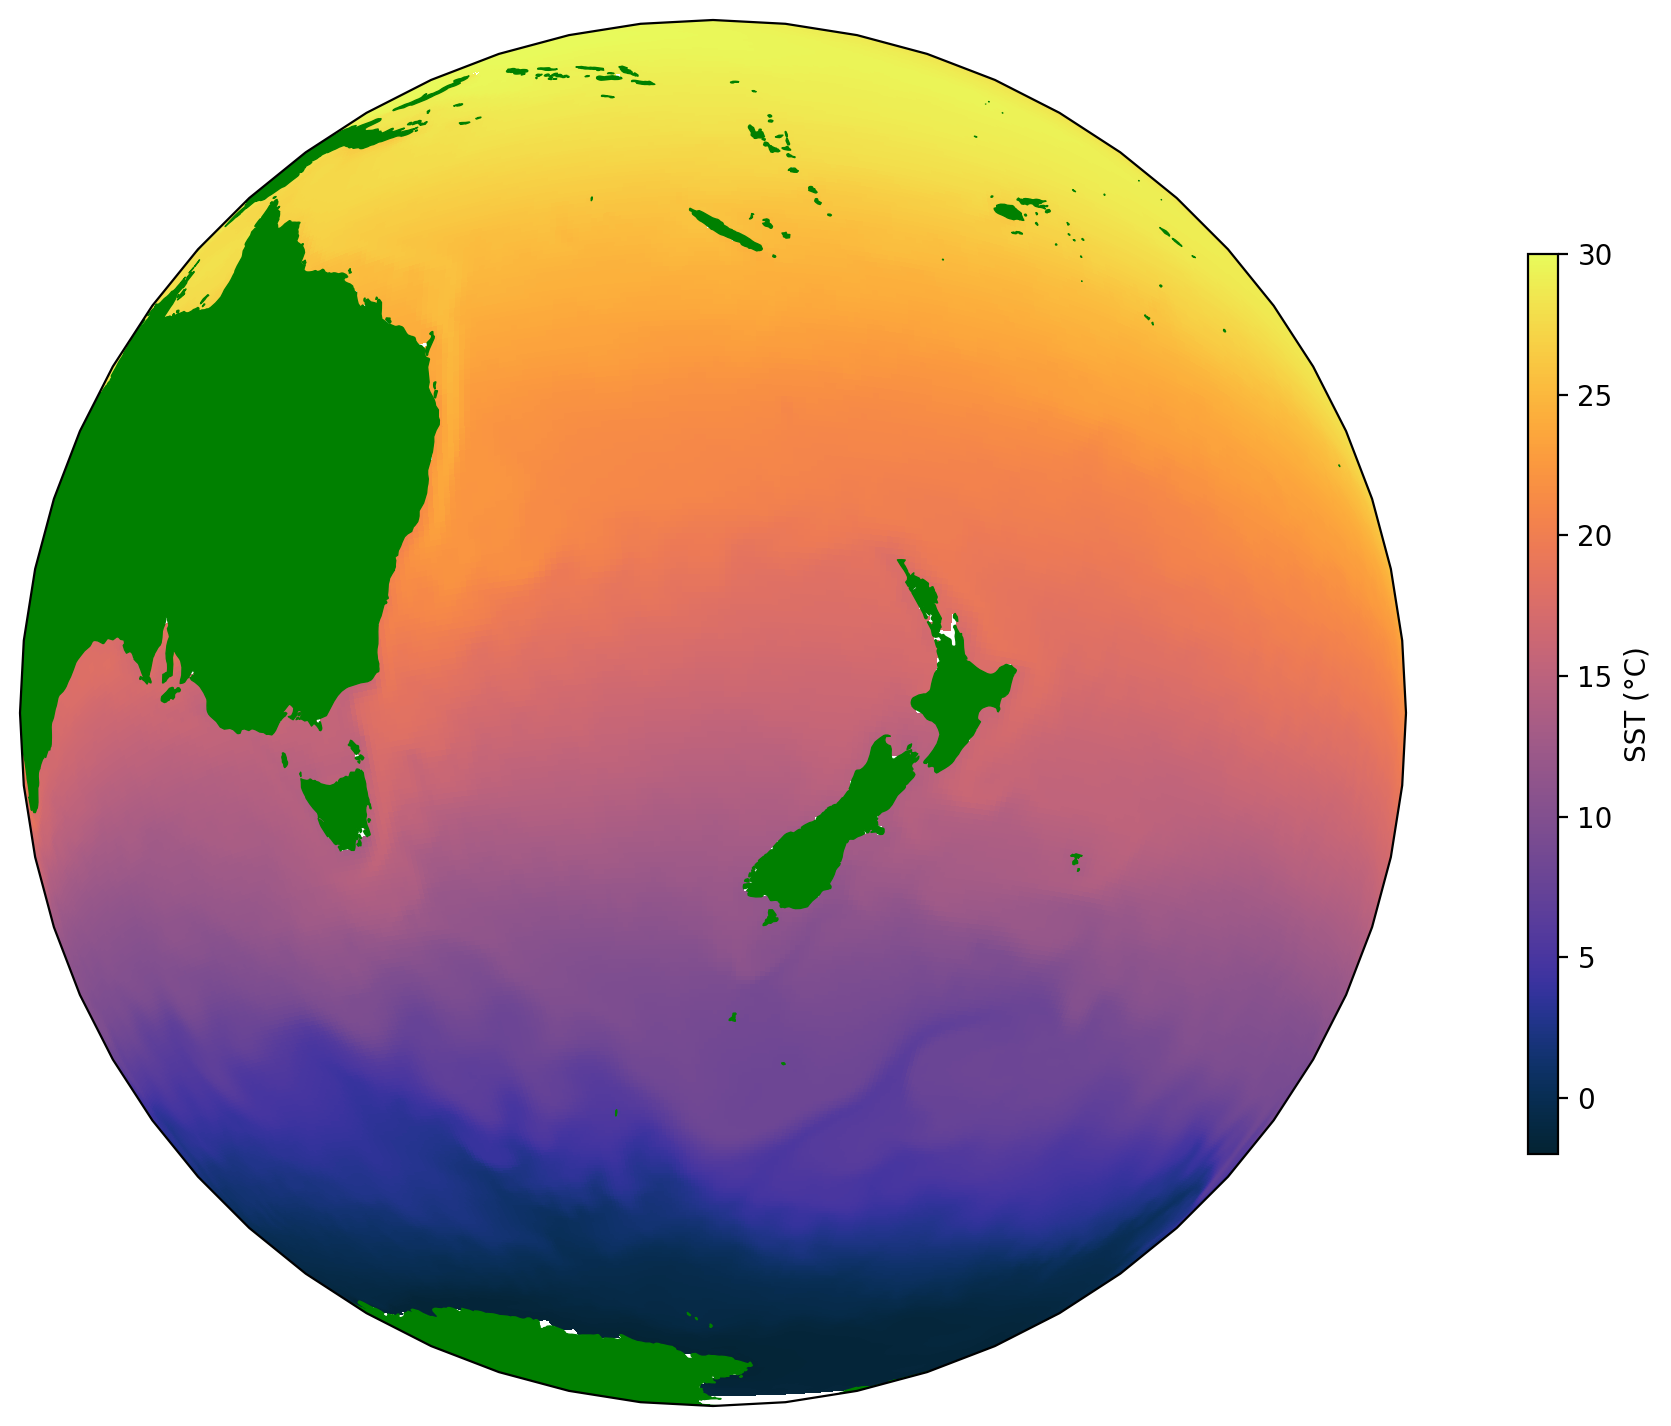

In [8]:
fig = plt.figure(figsize=(10,9))

ax = plt.axes(projection=ccrs.NearsidePerspective(central_longitude=165.0, central_latitude=-40.0, satellite_height=2500000))#=35785831))      
ax.add_feature(land_50m, color='g')

p1 = SST.plot.pcolormesh(x='longitude', y='latitude', add_colorbar=False, vmin=-2, vmax=30, cmap=cm.cm.thermal, transform=ccrs.PlateCarree())

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('SST (°C)');

### South Polar Stereo
Note that this plot, by default, shows the entire globe, which minimises the area of the South Pole region. So, we have to cut an area of the figure to focus down on it. 

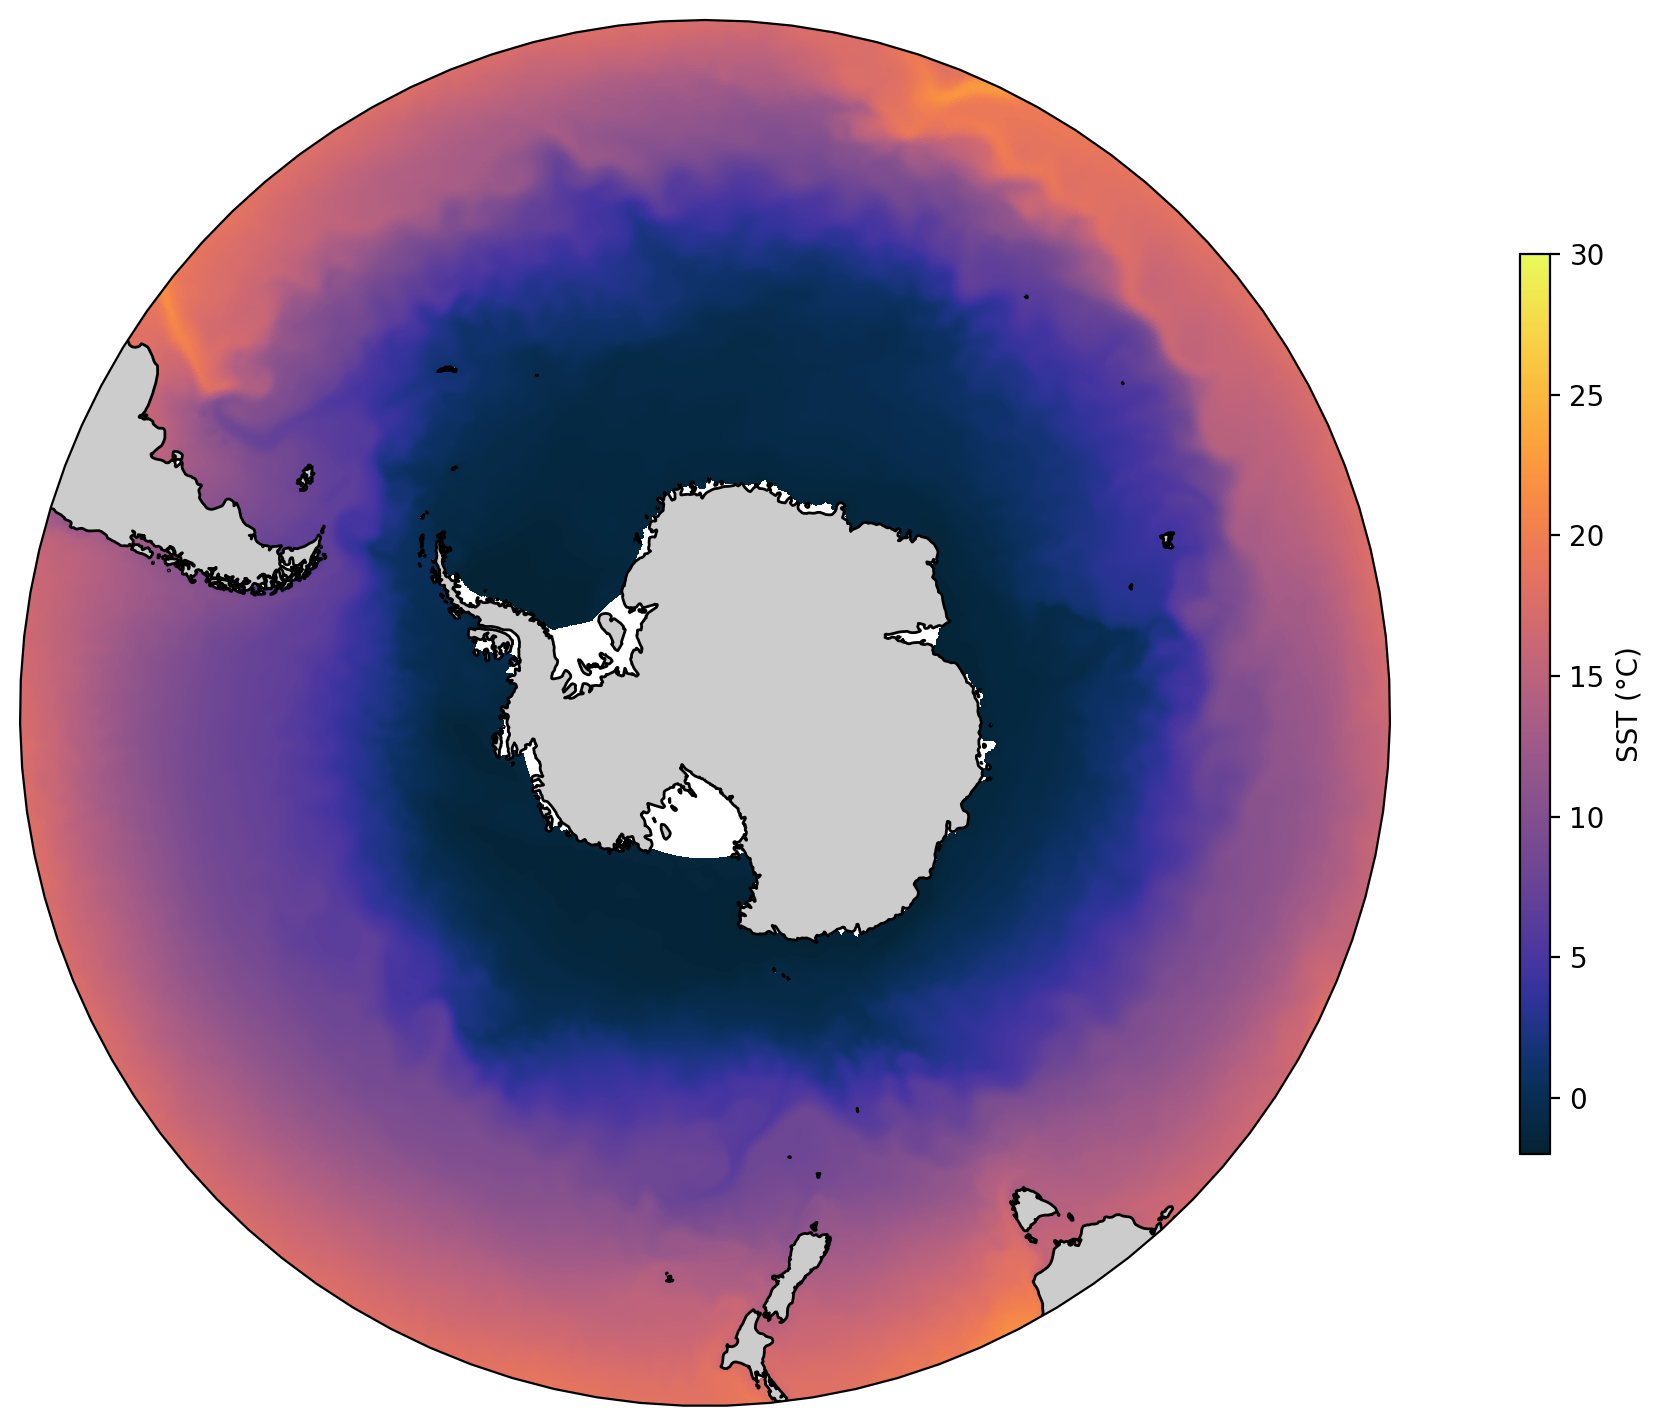

In [9]:
import matplotlib.path as mpath

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(1, 1, 1, projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


p1 = SST.plot.pcolormesh(x='longitude', y='latitude', add_colorbar=False, vmin=-2, vmax=30, cmap=cm.cm.thermal, transform=ccrs.PlateCarree())


ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('SST (°C)');

### Mercator regional plot

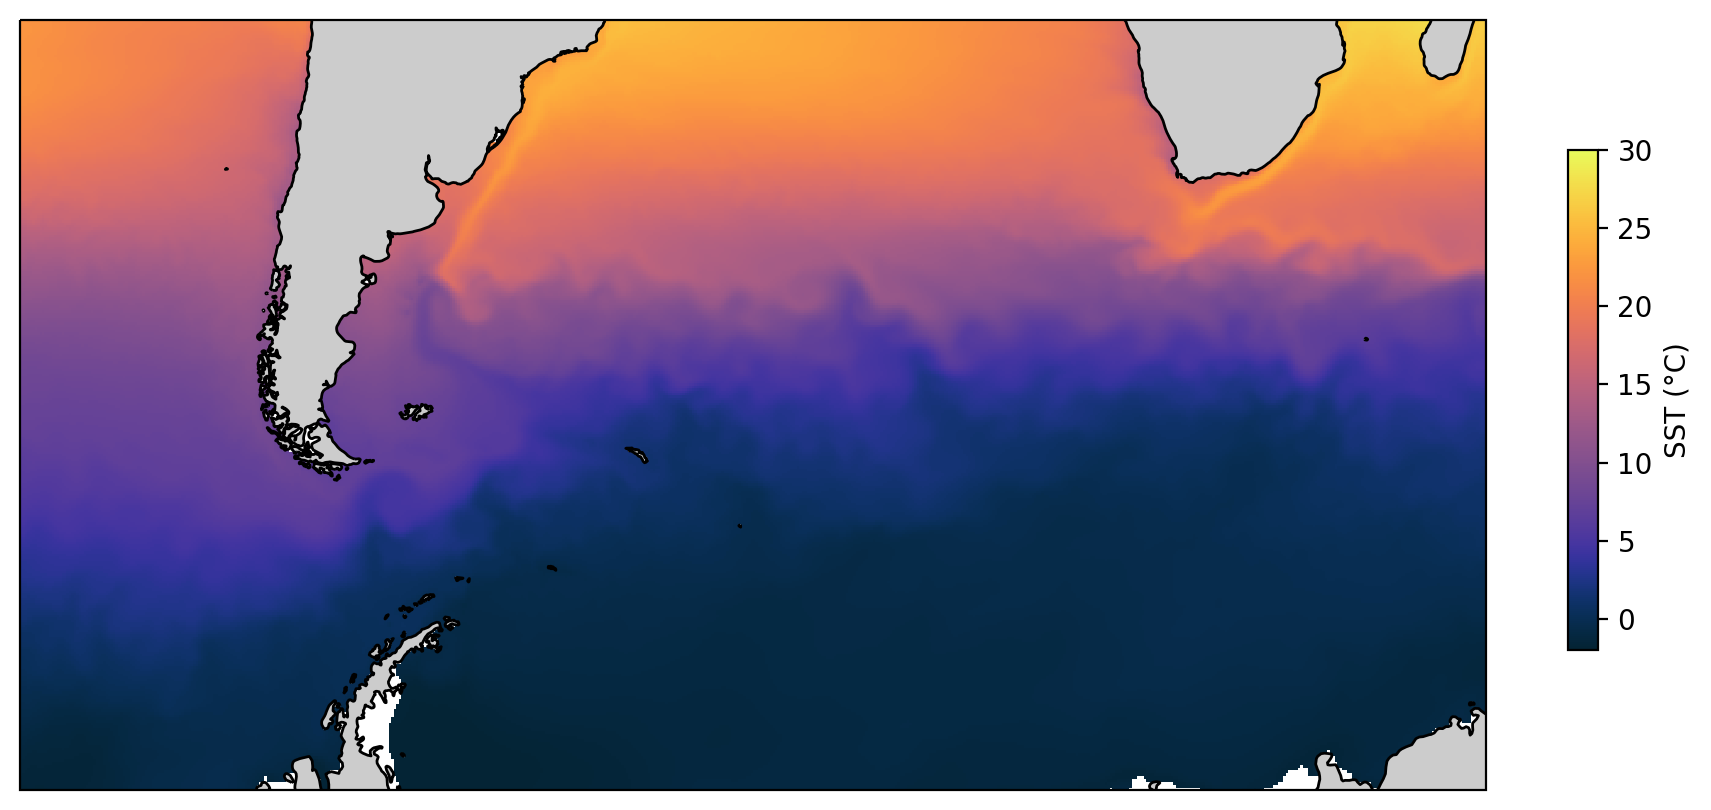

In [10]:
projection=ccrs.Mercator(central_longitude=0.0, min_latitude=-70.0, max_latitude=-20.0)

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 1, 1, projection=projection)


ax.set_extent([-100, 50, -70, -20], crs=ccrs.PlateCarree())
ax.add_feature(land_50m,color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')


p1=SST.plot.pcolormesh(x='longitude', y='latitude', add_colorbar=False, vmin=-2, vmax=30, cmap=cm.cm.thermal, transform=ccrs.PlateCarree())


ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('SST (°C)');

### Sector map

This map shows a sector of the Southern Ocean. It involves a Stereographic projection and a fairly complicated cutout to set the boundary of the map, but gives a nice result.

In [11]:
# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons,lats):
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

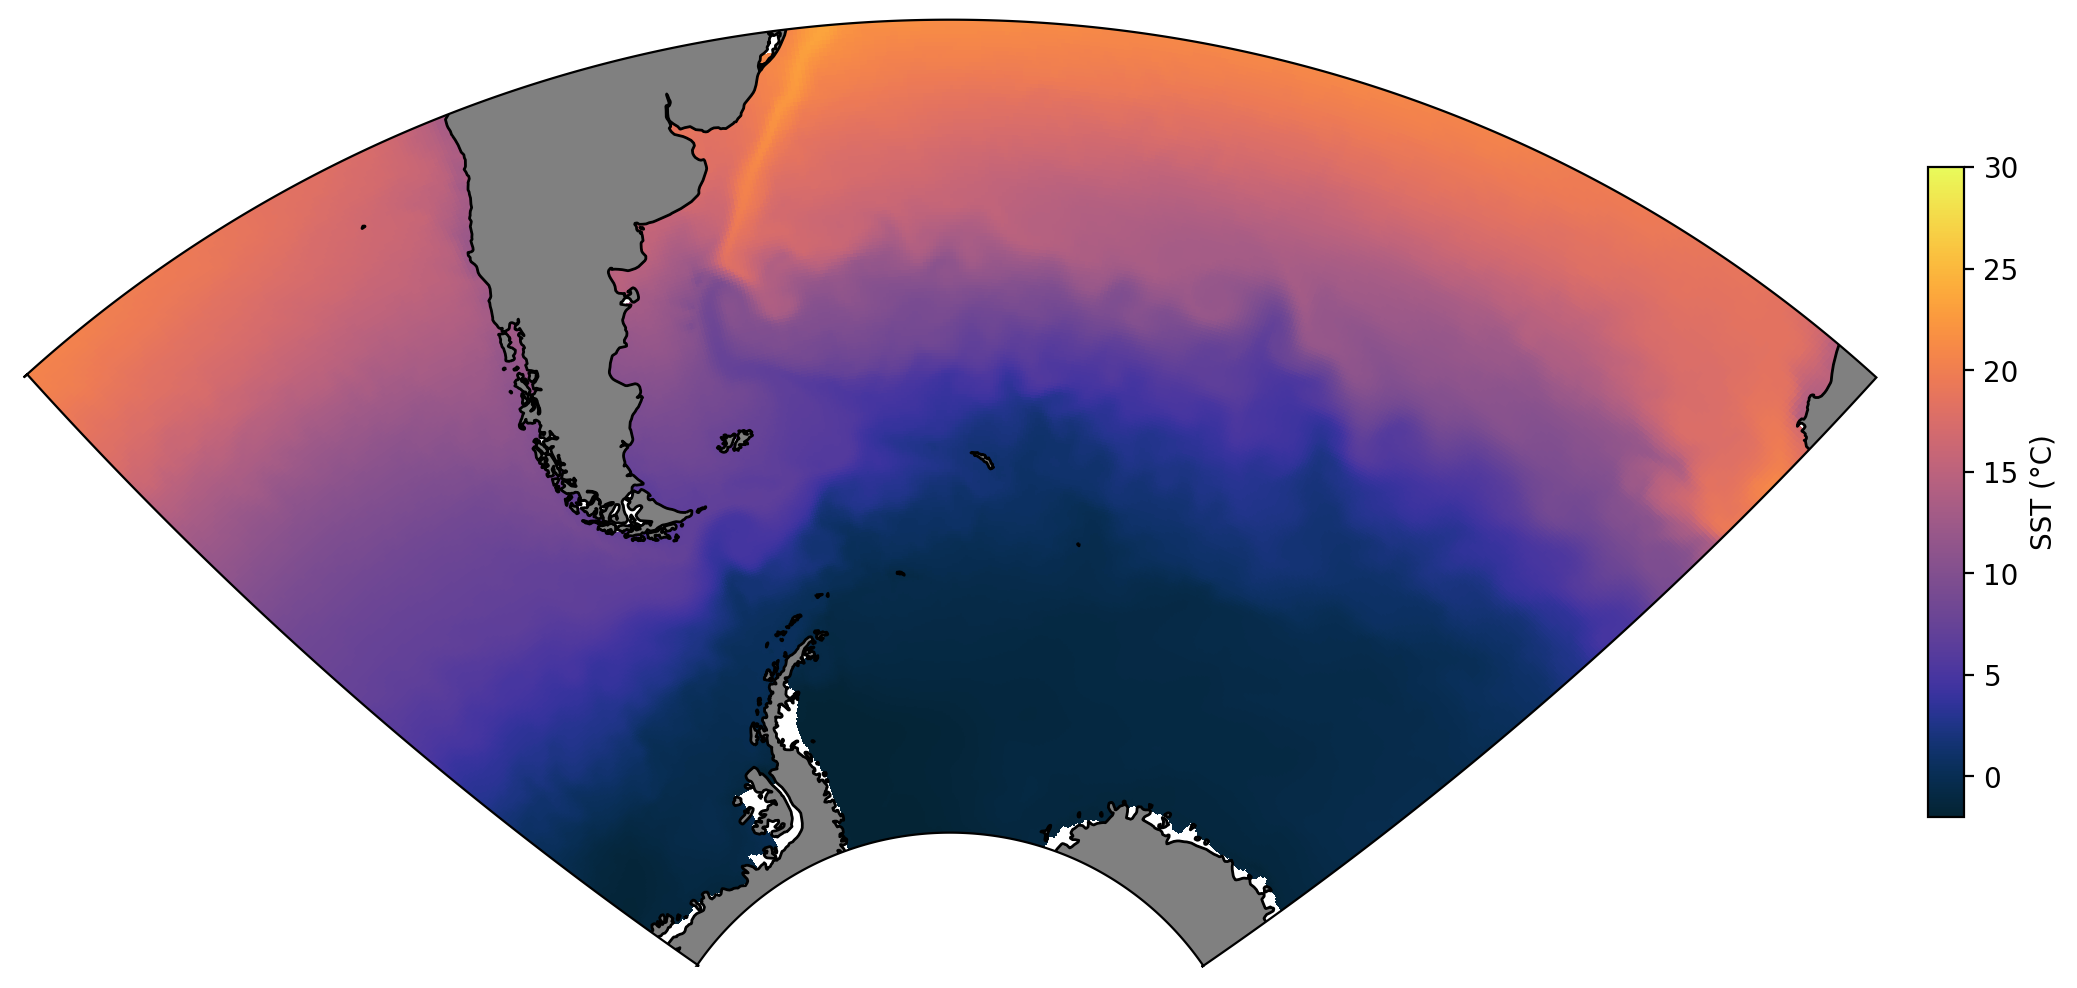

In [12]:
fig = plt.figure(figsize=(12,6.5))

midlon = -40
maxlon = midlon + 60
minlon = midlon-60
minlat = -75
maxlat = -30
midlat = (minlat + maxlat)/2

ax = plt.axes(projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat))
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')

lons = geolon_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))
lats = geolat_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))

ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

p1=SST.plot.pcolormesh(x='longitude', y='latitude', add_colorbar=False,vmin=-2,vmax=30,cmap=cm.cm.thermal,transform=ccrs.PlateCarree())

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('SST (°C)');

You can see a wider selection of cartopy projections here: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html